# ResNet50 : Images - Iteration #3(Without Data Augementation)

img_rows = 256 <br>
img_cols = 256 <br>
batch_size = 64 <br>
epochs = 40 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>

**<u>Results</u>**

Accuracy : 0.33 <br>
F1 score weighted : 0.29

**Import packages**

In [47]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Iteration #1 - ResNet50(Residual Networks)

***Read DataFrame from saved pickele file - image Train set***

In [2]:
#Load df of images already resized on 256 x 256 
df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

#Load df of images with org size 500 x 500
#df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_ORG_im_size_23112021.pkl")

In [3]:
df_train_im.head()

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,resized_image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,resized_image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,resized_image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,resized_image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,resized_image_1077757786_product_278535884.jpg


In [4]:
display(df_train_im.shape)

(84916, 6)

***Create Dataframe containing  product classes and their associated labels***

In [6]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                     60, 1320, 2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180,
                                     2403, 2462],                 
            
                    "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
                               "interior furniture and bedding", "board games", "interior accessories",
                               "toys for children","goodies", "remote controlled models", "decoration interior",
                               "piscine spa","games and consoles", "early childhood", "magazines", "kids toys",
                               "supplies for domestic animals", "imported video games", "online distribution of video games",
                               "gardening and DIY","Food","playing cards", "accessories children", "adult books",
                               "figurines_wargames", "children books",
                                "games"]
                   }
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [7]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


***Change the 27 product codes to 0 to 26***

In [8]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [9]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

 ***Convert product code to string type***

In [10]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [11]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

 ***Split Train Set***

In [ ]:
# Split Train set 
#X_train_im, X_test_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [ ]:
#display(X_train_im.shape)
#display(X_test_im.shape)

***Data Generator***

In [12]:
%%time
#Générateur de données
img_gen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

Wall time: 0 ns


In [30]:
img_rows = 256 # default for ResNet50
img_cols = 256 # default for ResNet50
batch_size = 64
epochs = 40
images_dir_train = './data/images/all/image_train_resized/'
#images_dir_test = './data/images/all/image_test_resized/'

In [31]:
%%time

#Itérateur 
train_generator = img_gen.flow_from_dataframe(dataframe = df_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True, # défault
                                              subset = 'training'
                                             )

Found 67933 validated image filenames belonging to 27 classes.
Wall time: 6.11 s


In [33]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = img_gen.flow_from_dataframe(dataframe = df_train_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False,
                                              subset  = 'validation'
                                             )

Found 16983 validated image filenames belonging to 27 classes.
Wall time: 5.47 s


 ***ResNet50 Implementation and Compilation***

In [34]:
%%time
# Freez des chouche pré_entrainées d'Extraction de Features
def make_model():
    base_model = ResNet50(
        include_top = False,
        weights ='imagenet',
        input_shape = (img_rows,img_rows,3),
        pooling ='avg'
    )
    for layer in base_model.layers:
        layer.trainable = False

    predictions = Dense(27, activation='sigmoid')(base_model.output)  # sigmoid à re vérifier !!!!!!!!!!!!
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = make_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

***Callbacks***

In [35]:
%%time
path = './saves/ResNet50/'
file_name = 'checkpoint_ResNet50_01122021-40Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch')
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0,
                      patience = 5, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,
                      verbose = 1,
                      mode = 'min')

Wall time: 0 ns


 ***Fit - train_generator***

In [37]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [39]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    callbacks = [checkpoint,early]                    
                    )

Epoch 1/40
1061/1061 [==============================] - 197s 185ms/step - loss: 2.6576 - accuracy: 0.2420 - val_loss: 2.6539 - val_accuracy: 0.2400

Epoch 00001: val_accuracy improved from 0.22465 to 0.23998, saving model to ./saves/ResNet50\checkpoint_ResNet50_01122021-40Epochs.h5
Epoch 2/40
1061/1061 [==============================] - 197s 186ms/step - loss: 2.6008 - accuracy: 0.2575 - val_loss: 2.6034 - val_accuracy: 0.2496

Epoch 00002: val_accuracy improved from 0.23998 to 0.24959, saving model to ./saves/ResNet50\checkpoint_ResNet50_01122021-40Epochs.h5
Epoch 3/40
1061/1061 [==============================] - 198s 186ms/step - loss: 2.5609 - accuracy: 0.2649 - val_loss: 2.5916 - val_accuracy: 0.2469

Epoch 00003: val_accuracy did not improve from 0.24959
Epoch 4/40
1061/1061 [==============================] - 197s 186ms/step - loss: 2.5250 - accuracy: 0.2742 - val_loss: 2.5408 - val_accuracy: 0.2768

Epoch 00004: val_accuracy improved from 0.24959 to 0.27683, saving model to ./sav

***Save History results***

In [40]:
# Save History results
path = './saves/ResNet50/'
filename = 'history_ResNet50_all_train_01122021_40Epoch'

In [41]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path + filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path + filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path + filename +'.pkl')

***Display Model loss , accuracy per epoch***

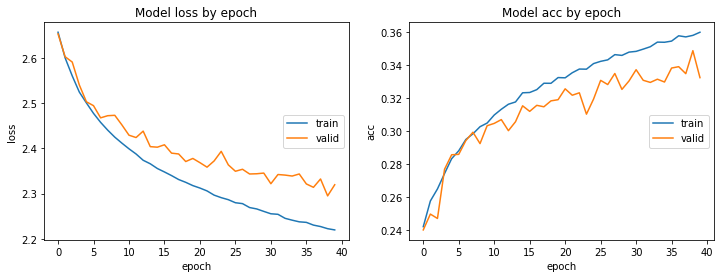

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

 ***Prediction - Valid_generator***

In [43]:
%%time
#Prediction - Test set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 37.8 s


 ***Evaluation - Valid_generator***

In [44]:
%%time
#Get the accuracy score
test_score = model.evaluate(valid_generator)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

266/266 [==============================] - 40s 150ms/step - loss: 2.3198 - accuracy: 0.3325
[INFO] accuracy: 33.25%
[INFO] Loss:  2.319768190383911
Wall time: 40.3 s


In [45]:
%%time
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.33      0.52      0.40       621
           1       0.35      0.20      0.26       483
           2       0.22      0.04      0.07       154
           3       0.24      0.07      0.11       508
           4       0.20      0.13      0.16       656
           5       0.28      0.17      0.21      1038
           6       0.61      0.40      0.48       848
           7       0.35      0.07      0.12       152
           8       0.40      0.06      0.10      1021
           9       0.50      0.01      0.02       168
          10       0.41      0.51      0.45       956
          11       0.46      0.34      0.39       939
          12       0.20      0.07      0.11       375
          13       0.38      0.15      0.22       290
          14       0.23      0.38      0.29       949
          15       0.50      0.00      0.01       508
          16       0.29      0.77      0.43      2061
          17       0.10    

 ***Predict input image using trained model***

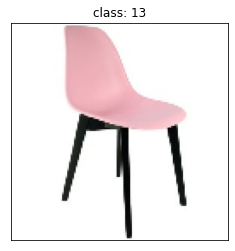

In [48]:
# Predict With Pre Trained

# Load an image
im_id = 10
img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(128, 128))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [50]:
im = cv2.resize(cv2.imread(img_path), (256, 256))
im = np.expand_dims(im, axis=0)

In [51]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['target_prdtypecode'] == int(prd_code)]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['target_prdtypecode'] == int(prd_code)][['prdtypecode', 'Label']].to_string(index=False))  


------------------Predicted Class and Label ------------------------------
target class(used by model) : 0

  prdtypecode       Label
          10 adult books


------------------Real Class and Label ------------------------------
target class(used by model):  13

  prdtypecode                          Label
        1560 interior furniture and bedding


 ***Save ResNet Model***

In [52]:
#Enregistrement du modèle 
model.save("./saves/ResNet50/ResNet50_All_train_data_011212021_40Epochs.hdf5")

#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

C:\Users\MME\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


 ***Load ResNet Model***

In [ ]:
#Rechargement du modèle :
model = load_model('./saves/ResNet50/ResNet50_All_train_data_011212021_40Epochs.hdf5')
